# Controlled Small Molecule Generation for Drug Discovery using the MolMIM NIM with Custom Oracles

## Get the MolMIM NIM up and running
Please refer to the [NVIDIA MolMIM NIM docs](https://docs.nvidia.com/nim/bionemo/molmim/latest/index.html) and [QuickStart guide](https://docs.nvidia.com/nim/bionemo/molmim/latest/quickstart-guide.html) for more information.

First login to the nvcr.io docker registry with your API key.
Then run the following command to download and start the MolMIM server. It will pull the docker container and the required model weights from NGC.
```bash
    export NGC_CLI_API_KEY=<PASTE_API_KEY_HERE>

    docker run --rm -it --name molmim --runtime=nvidia \
        -e CUDA_VISIBLE_DEVICES=0 \
        -e NGC_CLI_API_KEY \
        -p 8000:8000 \
        nvcr.io/nim/nvidia/molmim:1.0.0
 ```

In the field of drug discovery, identifying novel and effective compounds is a crucial step in the development of new medicines. Chemical space, the vast expanse of all possible chemical compounds, is a complex landscape that can be difficult to navigate. Molecular generative AI models, such as MolMIM, can be used to sample this space and identify promising compounds.

## CMA-ES: A Global Optimization Algorithm

CMA-ES (Covariance Matrix Adaptation Evolution Strategy) is a global optimization algorithm that is well-suited for optimizing complex objective functions such as the QED score. It uses a population of candidate solutions to search for the optimal solution, and adapts the covariance matrix of the search distribution to improve the search process.

## Objectives

In this notebook, we will use MolMIM to perform guided optimization on an imatinib seed using CMA-ES and a custom oracle scoring function to optimize for desired properties.

## Setup

We'll first install and import required dependencies, including the RDKit QED and TanimotoSimilarity functions that we'll use to construct our oracle scoring function.

In [ ]:
!pip install cma matplotlib numpy pandas rdkit

In [1]:
import cma
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
from IPython.display import display, clear_output
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.QED import qed
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs import TanimotoSimilarity
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')

### Define the NIM host
To get started, we'll define our NIM host and the NIM endpoints we'll use in the following cells.

 - `/sampling` - Perform random sampling around a seed SMILES to define a starting population
 - `/hidden` - Generate the hidden state encoding for a set of input SMILES
 - `/decode` - Decode hidden state encodings to return a set of SMILES

In [2]:
nim_host="localhost"
port="8000"
sampling_url=f"http://{nim_host}:{port}/sampling"
hidden_url=f"http://{nim_host}:{port}/hidden"
decode_url=f"http://{nim_host}:{port}/decode"

Let's run a health check on our NIM:

In [3]:
!curl {nim_host}:{port}/v1/health/ready

{"status":"ready"}

## Guided Molecular Generation with CMA-ES

In contrast to the random sampling of the latent space described above, we can use a black box optimizer, called CMA-ES, to perform guided optimization of the a molecule's property through sampling of the latent space. In the blocks below, we'll first generate and score a population of candidate molecules using random sampling, and then use CMA-ES to optimize for a custom scoring function based on QED and Tanimoto Similarity.


The following code block defines a function called `tanimoto_similarity` that calculates the Tanimoto similarity between two molecules. The function takes two parameters: `smiles`, the SMILES string of the molecule to be compared, and `reference`, the SMILES string of the reference molecule. The function first gets the fingerprint parameters, then creates the fingerprint for the reference molecule. It then validates the input molecule by converting its SMILES string to a molecule object and checks if the object is None. If the object is None, it returns 0. Otherwise, it creates the fingerprint for the input molecule and calculates the Tanimoto similarity between the two fingerprints. The function returns the calculated Tanimoto similarity.

This function will be used along with the RDKit QED function to score both the randomly sampled population and to construct the oracle scoring function used with CMA-ES guided optimization.

In [4]:
def tanimoto_similarity(smiles, reference: str):
    # Get fingerprint params
    fingerprint_radius_param = 2
    fingerprint_nbits = 2048

    # Handle the reference molecule
    reference_mol = Chem.MolFromSmiles(reference)
    reference_fingerprint = GetMorganFingerprintAsBitVect(
        reference_mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits
    )

    # Validate the other molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    fingerprint = GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits)

    # Calculate and return the Tanimoto similarity
    return TanimotoSimilarity(fingerprint, reference_fingerprint)

### First an example using random sampling around the imatinib seed

In the following block, we define the imatinib seed and use the `/sampling` endpoint to randomly sample latent space to generate a candidate population.  We then calculate the average Tanimoto similarity and QED for this population.



In [5]:
# Define a starting array of seed SMIs

imatinib = 'CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5'

mol = Chem.MolFromSmiles(imatinib)
imatinib_qed = qed(mol)

starting_smiles = [
    imatinib,
    imatinib,
    imatinib,
    imatinib,
    imatinib
]

generated_smiles = []
tanimoto_scores = []
qed_scores = []
sampling_summary = {}

# Create the request data
for smi in starting_smiles:
    data = {
        'sequences': [smi],
        'beam_size': 3,
        'num_molecules': 10,
        'scaled_radius': 1.0,
    }

    # Send the request and get the response
    headers = {'Content-Type': 'application/json'}
    response = requests.post(sampling_url, headers=headers, json=data)
    
    # Parse the response as JSON
    response_json = json.loads(response.text)
    
    # Extract the generated SMILES strings
    generated_molecules = response_json['generated'][0]
    
    # Filter out invalid SMILES strings
    valid_smiles = [m for m in generated_molecules if Chem.MolFromSmiles(m) is not None]
    generated_smiles.extend(valid_smiles)

# Calculate Tanimoto similarity and QED score for each valid SMILES string
for smile in generated_smiles:
    mol = Chem.MolFromSmiles(smile)
    if mol:
        tanimoto = tanimoto_similarity(smile, imatinib)
        qed_score = qed(mol)
        tanimoto_scores.append(tanimoto)
        qed_scores.append(qed_score)

# Sampling summary - valid smiles count, average Tanimoto and QED scores
sampling_summary['valid_smiles']=len(generated_smiles)
sampling_summary['tanimoto_similarity'] = np.mean(tanimoto_scores)
sampling_summary['qed_score'] = np.mean(qed_scores)

print(f"Valid SMILES = {sampling_summary['valid_smiles']}, mean TS = {sampling_summary['tanimoto_similarity']}, mean QED = {sampling_summary['qed_score']}")


Valid SMILES = 50, mean TS = 0.2626503530738372, mean QED = 0.7402966948118029


### Custom Scoring Oracle

Next, we'll define a custom oracle scoring function. This function is based on QED and tanimoto similarity scores, and is what was used for property optimization in the [MolMIM paper](https://arxiv.org/abs/2208.09016). 

$$
   score = min(QED / 0.9, 1) + min(Tanimoto / 0.4, 1)
$$

This oracle tries to maximize QED and similarity score, up to QED of 0.9 and similarlity of 0.4, beyond which there is no more gain.  Note that we return the inverse of the calculated score, as CMA-ES will work to maximize this value.

In [6]:
def scoring_function(qeds, similarities) -> np.ndarray:
    return -1. * (np.clip(np.array(qeds) / 0.9, a_min=0.0, a_max=1.0) + np.clip(np.array(similarities) / 0.4, a_min=0.0, a_max=1.0))

scores = scoring_function(qed_scores, tanimoto_scores)

We can then plot the scores of the randomly sampled candidates in our search space.

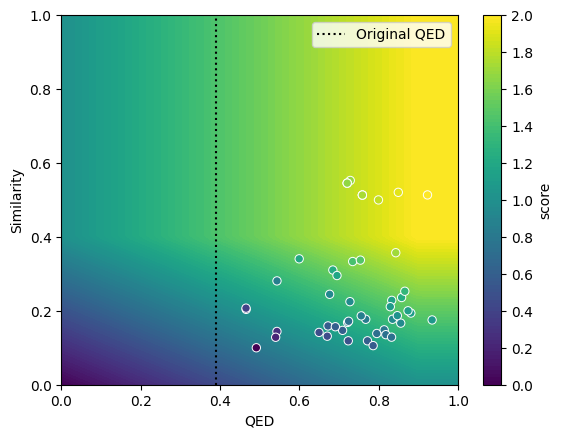

In [7]:
%matplotlib inline
plt.ion()
fig, ax = plt.subplots()
deltas = np.linspace(0, 1, 100)
Xgrid, Ygrid = np.meshgrid(deltas, deltas)
score_background = -1*scoring_function(Xgrid, Ygrid)
plt.contourf(Xgrid, Ygrid, score_background, levels=100, vmin=0, vmax=2.0)
plt.colorbar(label='score', ticks=np.linspace(0,2,11))
plt.plot([imatinib_qed, imatinib_qed], [0, 1], linestyle=':', c='k', label="Original QED")
plt.scatter(qed_scores, tanimoto_scores, c=-1*scores, edgecolor='1.0', linewidths=0.7)
plt.xlabel("QED")
plt.ylabel("Similarity")
plt.legend()
plt.draw()



## Controlled Generation with CMA-ES and the custom oracle

### Generate hidden state encoding for the imatinib seed to initialize CMA-ES

To start the CMA-ES optimization process, we first seed the optimizer with the hidden state encoding for our imatinib seed molecule using the `/hidden` endpoint.

In [8]:
# First calculate a hidden state representation of our seed, imatinib.
headers = {
    'accept': 'application/json',
    'Content-Type': 'application/json'
}
data = {
    "sequences": [imatinib],
}

# Get the response from the server
response = requests.post(hidden_url, headers=headers, json=data)
imatinib_hidden = np.squeeze(np.array(response.json()["hiddens"]))

# We can use this seed hidden state as a starting point for our CMA-ES optimizer
popsize = sampling_summary['valid_smiles']
sigma=1.0

# Initialize with zeros or the hidden state encoding for imatinib
#optimizer = cma.CMAEvolutionStrategy(np.zeros(imatinib_hidden.size, dtype=np.float32), sigma, {'popsize': popsize})
optimizer = cma.CMAEvolutionStrategy(imatinib_hidden, sigma, {'popsize': popsize})

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 512 (seed=182704, Wed Sep 11 15:24:12 2024)


Now that we've initialized the CMA-ES optimizer, we can generate and decode an initial set of trial encodings using the `/decode` endpoint.

In [9]:
# Generate and decode a set of initial trial encodings with CMA-ESecode trial encodings

trial_encodings=optimizer.ask(popsize)

headers = {
    'accept': 'application/json',
    'Content-Type': 'application/json'
}
hiddens_array = np.expand_dims(np.array(trial_encodings), axis=1)
hiddens_json = {"hiddens":hiddens_array.tolist(),
                "mask": [[True] for i in range(hiddens_array.shape[0])]}


response = requests.post(decode_url, headers=headers, json=hiddens_json)
molecules = list(dict.fromkeys(response.json()['generated']))

We can then calculate the scores for this trial population and plot the results in our search space.

Current popsize = 49


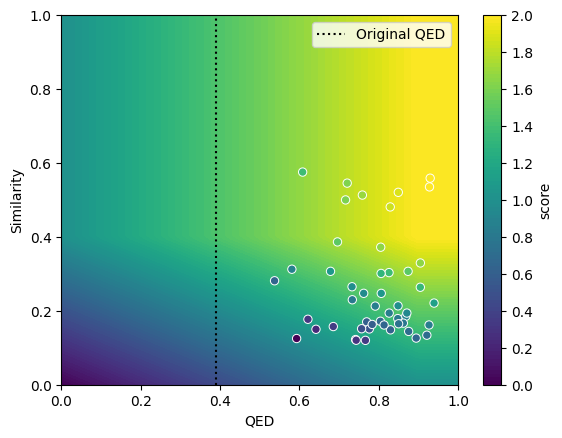

In [10]:
%matplotlib inline

# Calculate Tanimoto similarity and QED score for each valid SMILES string
tanimoto_scores= []
qed_scores = []
for smile in molecules:
    mol = Chem.MolFromSmiles(smile)
    if mol:
        tanimoto = tanimoto_similarity(smile, imatinib)
        qed_score = qed(mol)
        tanimoto_scores.append(tanimoto)
        qed_scores.append(qed_score)

scores = scoring_function(qed_scores, tanimoto_scores)

# update popsize based on the number of scores from valid molecules
popsize=len(scores)
print(f"Current popsize = {popsize}")

# Plot
plt.ion()
fig, ax = plt.subplots()
plt.contourf(Xgrid, Ygrid, score_background, levels=100, vmin=0, vmax=2.0)
plt.colorbar(label='score', ticks=np.linspace(0,2,11))
plt.plot([imatinib_qed, imatinib_qed], [0, 1], linestyle=':', c='k', label="Original QED")
plt.scatter(qed_scores, tanimoto_scores, c=-1*scores, edgecolor='1.0', linewidths=0.7)
plt.xlabel("QED")
plt.ylabel("Similarity")
plt.legend()
plt.draw()

### Iterative optimization with CMA-ES and the custom oracle function
Now that we have our starting population, we can iteratively optimize using the CMA-ES strategy:

1. Generate a new set of trial encodings
2. Decode and calculate scores
3. Generate a new set of hidden state representations for valid trial candidates
4. Update the CMA-ES optimizer with the current combination of scores and hidden state representations

Note that through the CMA-ES optimization loop, we will occasionally encounter invalid SMILES depending on the search parameters.  We will stop the CMA-ES optimization loop if we have reduced our starting population by half.

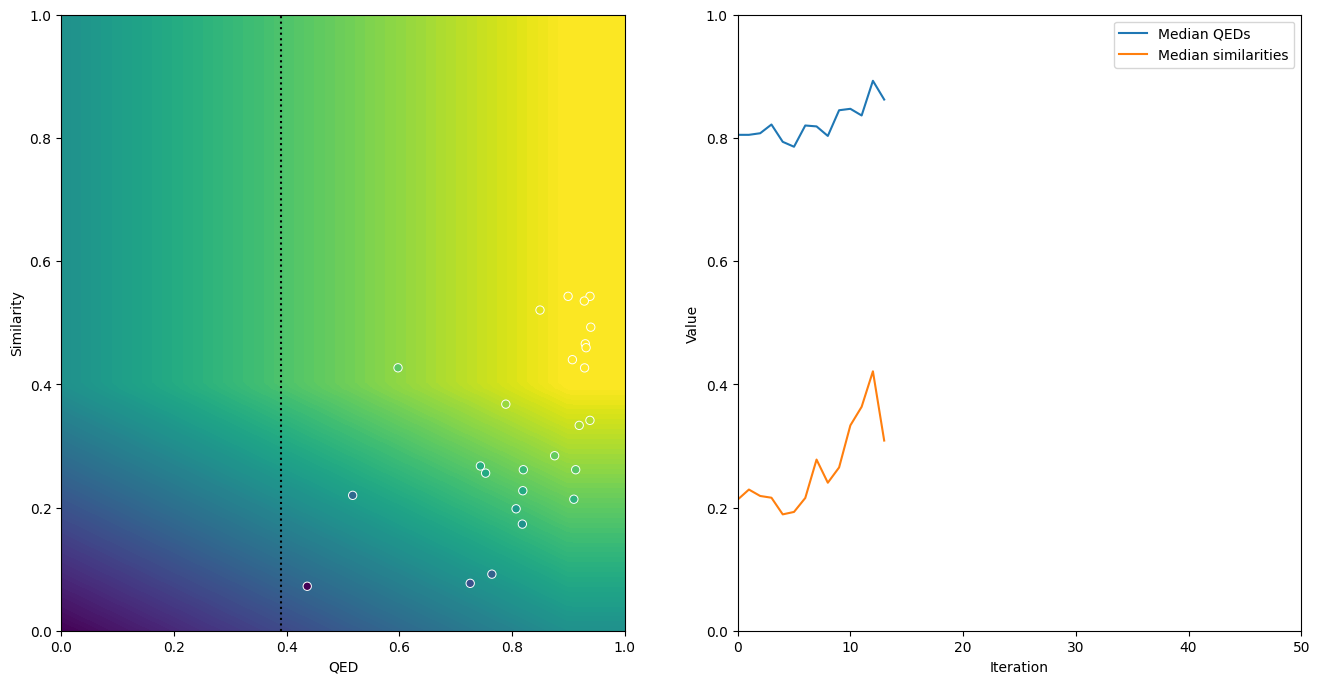

Size trial encodings = 26
Valid SMILES at it 13 = 23
Stopping at minimum population size 23



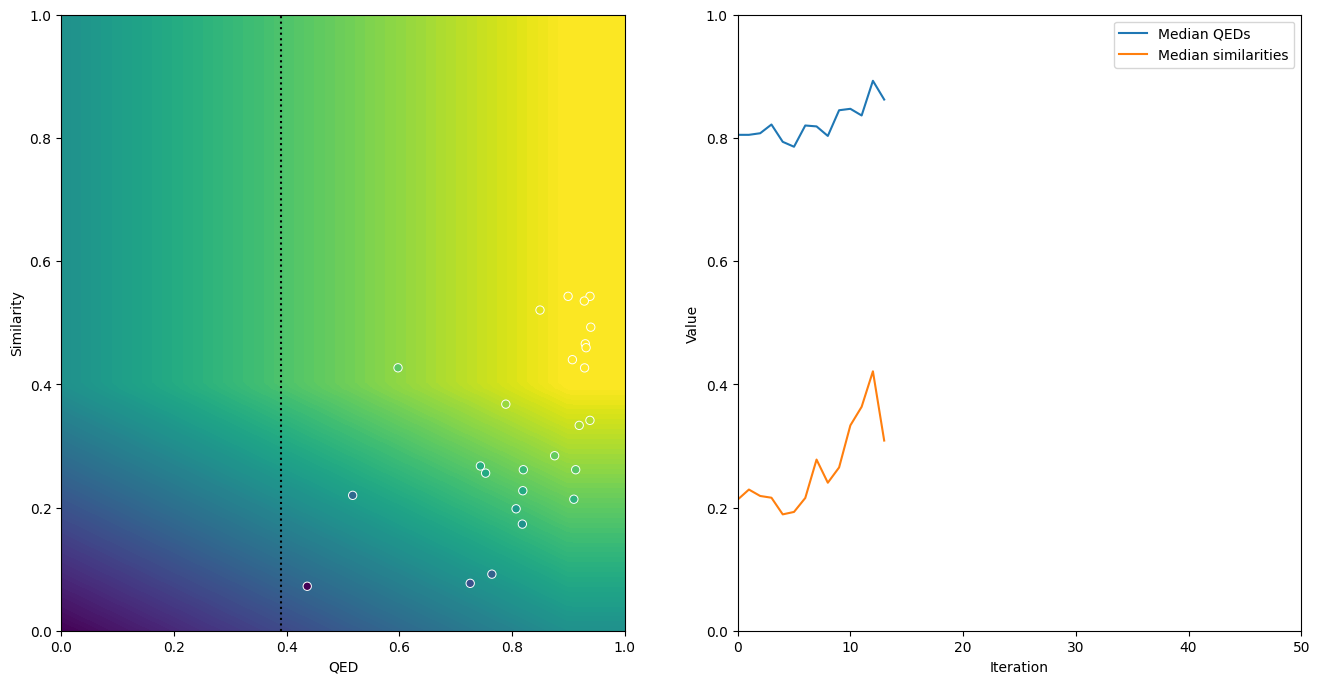

In [11]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(16)
med_qeds = [np.median(np.array(qed_scores))]
med_sims = [np.median(np.array(tanimoto_scores))]

# CMA-ES requires at least half of the starting population size
minpopsize = popsize/2

n_steps=50

for i in range(n_steps):
    trial_encodings=optimizer.ask(popsize)
    print(f"Size trial encodings = {len(trial_encodings)}")

    # Decode trial encodings for a new set of candidate molecules
    headers = {
        'accept': 'application/json',
        'Content-Type': 'application/json'
    }
    hiddens_array = np.expand_dims(np.array(trial_encodings), axis=1)
    hiddens_json = {"hiddens":hiddens_array.tolist(),
                    "mask": [[True] for i in range(hiddens_array.shape[0])]}

    response = requests.post(decode_url, headers=headers, json=hiddens_json)

    # Deduplicate the list of generated molecules
    molecules = list(dict.fromkeys(response.json()['generated']))
    valid_smiles = [m for m in molecules if Chem.MolFromSmiles(m) is not None]

    # Generate updated encodings for valid smiles
    headers = {
    'accept': 'application/json',
    'Content-Type': 'application/json'
    }
    data = {
        "sequences": valid_smiles,
    }
    response = requests.post(hidden_url, headers=headers, json=data)
    hiddens_array = np.squeeze(np.array(response.json()["hiddens"]))

    # Calculate Tanimoto similarity and QED score for each valid SMILES string
    tanimoto_scores= []
    qed_scores = []
    for smile in valid_smiles:
        mol = Chem.MolFromSmiles(smile)
        if mol:
            tanimoto = tanimoto_similarity(smile, imatinib)
            qed_score = qed(mol)
            tanimoto_scores.append(tanimoto)
            qed_scores.append(qed_score)

    # Update CMA-ES with current hiddens_array and scores
    scores = scoring_function(qed_scores, tanimoto_scores)
    popsize=len(scores)
    print(f"Valid SMILES at iteration {i} = {popsize}")

    if popsize <= minpopsize:
        print(f"Stopping at minimum population size {popsize}\n")
        break
    else:
        optimizer.tell(np.squeeze(np.array(hiddens_array)), scores)
    
        # plots
        ax1.clear()
        clear_output(wait=True)
        ax1.contourf(Xgrid, Ygrid, score_background, levels=100, vmin=0, vmax=2.0)
        ax1.set_xlabel('QED')
        ax1.set_ylabel('Similarity')
        ax1.plot([imatinib_qed, imatinib_qed], [0, 1], linestyle=':', c='k', label="Original QED")
        ax1.scatter(qed_scores, tanimoto_scores, c=-1*scores, edgecolor='1.0', linewidths=0.7)
        
        ax2.clear()
        med_qeds.append(np.median(qed_scores))
        med_sims.append(np.median(tanimoto_scores))
        ax2.plot(med_qeds, label='Median QEDs')
        ax2.plot(med_sims, label='Median similarities')
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Value")
        ax2.set_xlim(0, n_steps)
        ax2.set_ylim(0, 1)
        ax2.legend()
        display(fig)



## Viewing the resulting optimized molecules.

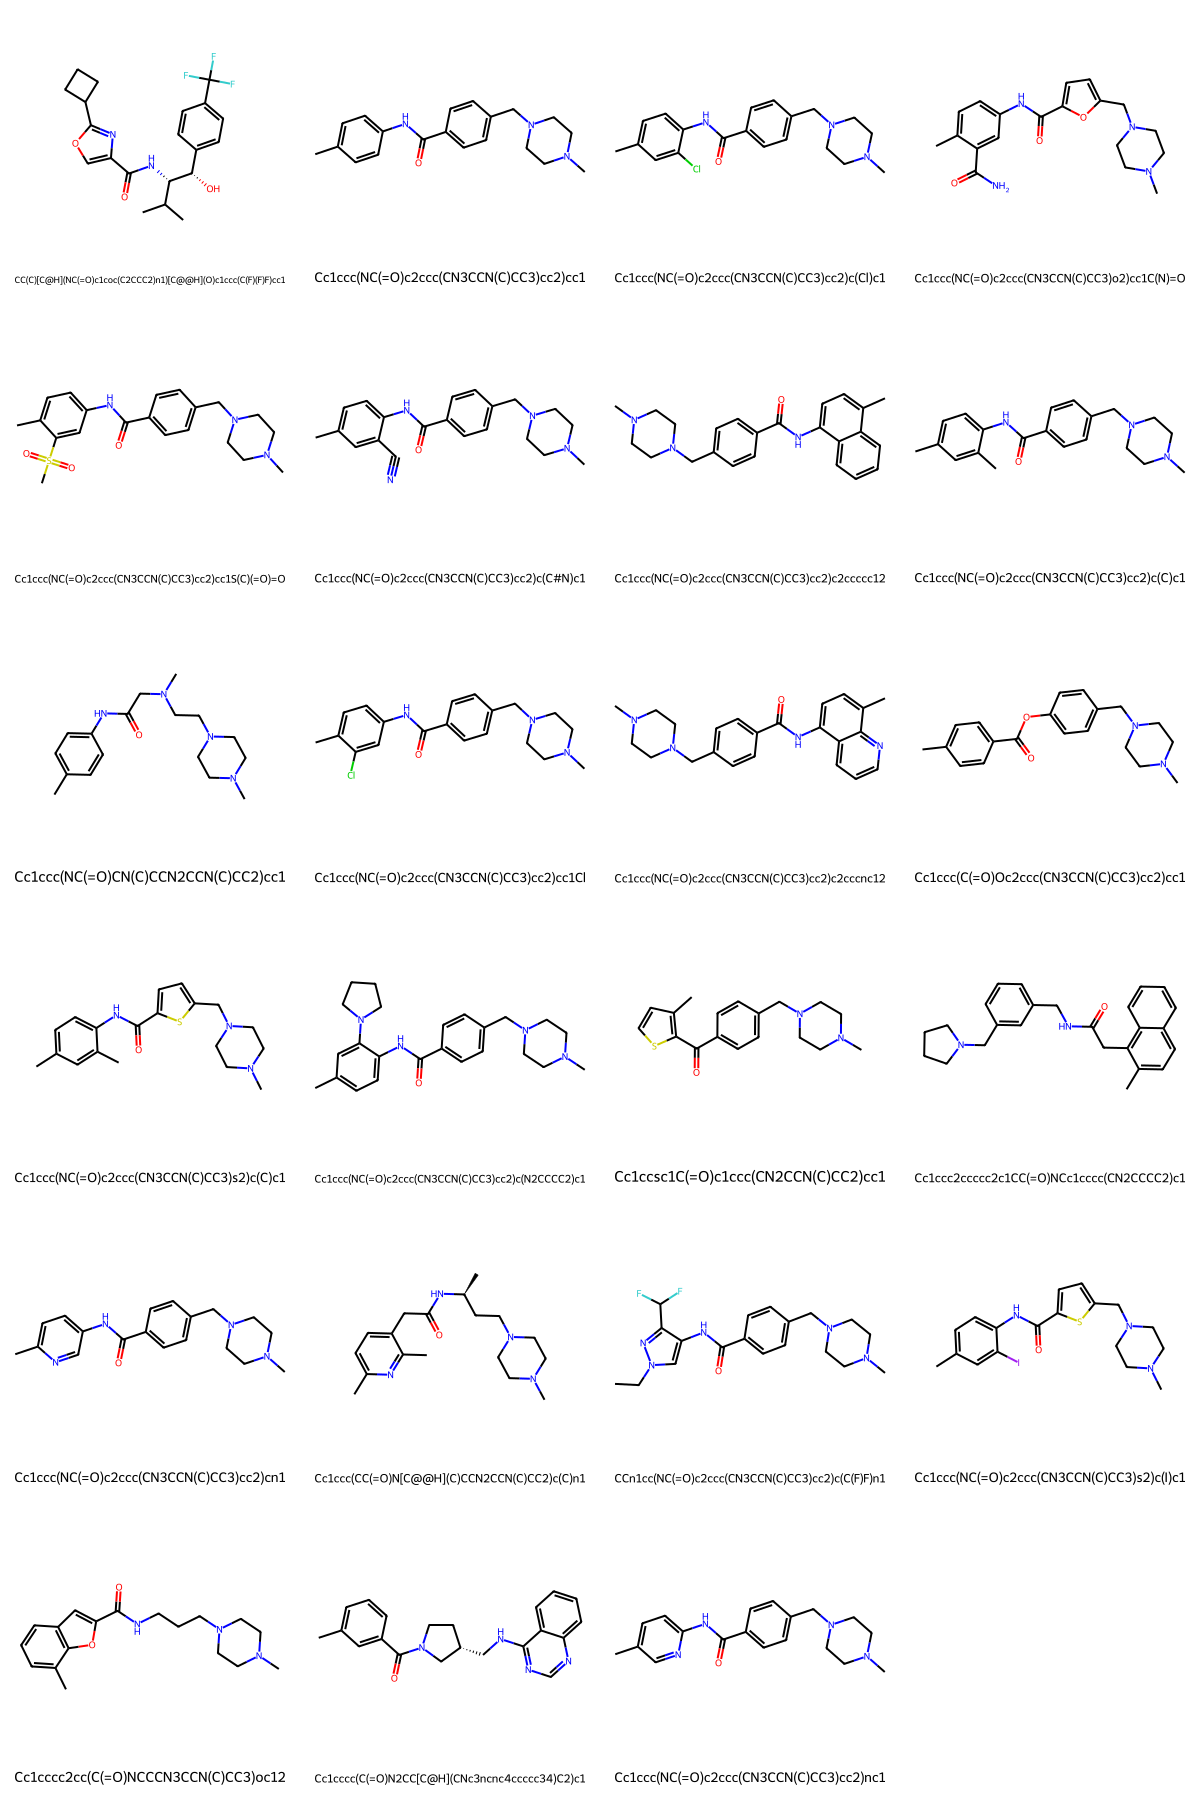

In [12]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smile, sanitize=False) for smile in valid_smiles],
                     legends=molecules, molsPerRow=4, subImgSize=(300, 300))